In [1]:
from framed.io_utils.sbml import load_cbmodel
from scipy.io import loadmat
import pandas as pd
import seaborn as sns
%pylab inline
sns.set_style("white")

Populating the interactive namespace from numpy and matplotlib


In [2]:
%run '../src/gpr_mapping.py'

## Load glycolysis model and gene names

In [3]:
model = load_cbmodel('../../models/glycolysis.xml', flavor='cobra')
model_ext = transform(model, inplace=False)

gene_names = pd.read_csv('../../models/mappings_gene_id_name.csv', index_col=0, header=None)
gene_names = dict(gene_names[1])

## Load CNA results

In [4]:
dumped = loadmat('../../results/EFMs/EFMs_glycolysis.mat')
efms = pd.DataFrame(dumped['efms'].T, index=model.reactions)

dumped = loadmat('../../results/EFMs/EFMs_glycolysis_unfolded.mat')
efms_ext = pd.DataFrame(dumped['efms'].T, index=model_ext.reactions)

## Calculate frequency distributions

In [31]:
rxn_freq = sum(efms != 0, axis=1) / efms.shape[1]
rxn_ext_freq = sum(efms_ext != 0, axis=1) / efms_ext.shape[1]

gene_freq = rxn_ext_freq[rxn_ext_freq.index.str.startswith('u_')]
gene_freq.sort_values(inplace=True, ascending=False)

rxn_freq2 = model_ext.convert_fluxes(rxn_ext_freq.to_dict(), net=False)
data = {r_id: (round(rxn_freq[r_id], 2), round(rxn_freq2[r_id],2)) for r_id in model.reactions}
ocurrences = {point: data.values().count(point) for point in set(data.values())}     

## Plot gene participation and reaction frequency

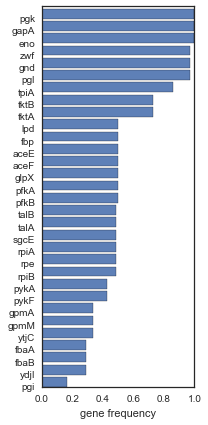

In [55]:
plt.figure(figsize=(3,6))
gene_freq.sort_values(inplace=True, ascending=True)
plt.barh(range(len(gene_freq)), gene_freq.values, alpha=0.9)
labels = [gene_names[r_id[len('u_'):]] for r_id in gene_freq.index]
plt.yticks(arange(len(model_ext.genes)), labels);
plt.ylim((0, len(model_ext.genes)))
plt.xlabel('gene frequency')
plt.tight_layout()
plt.savefig('../../results/EFMs/gene_frequency.png', dpi=150)

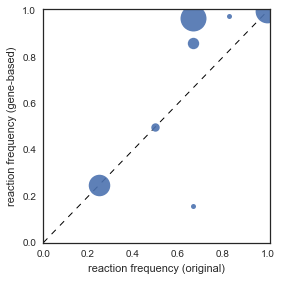

In [56]:
plt.figure(figsize=(4,4))
plt.plot([0,1], [0,1], 'k--', linewidth=1)
colors = sns.color_palette()
for (x, y), occur in ocurrences.items():
    plt.plot(x, y, '.', color=colors[0], alpha=0.9, markersize=10*occur**0.75)
plt.xlim((0,1.01))
plt.ylim((0,1.01))
plt.xlabel('reaction frequency (original)')
plt.ylabel('reaction frequency (gene-based)')
plt.tight_layout()
plt.savefig('../../results/EFMs/reaction_frequency.png', dpi=150)